In [1]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


#2. Get the file   
downloaded = drive.CreateFile({'id':'15m4e1JbUncRhKmPj8YfrBIefJKBVcUCZ'}) 
#file name
downloaded.GetContentFile('ks-projects-201801.csv') 

downloaded = drive.CreateFile({'id':'1ROXl1B5202_Z0xs56gfblIg7CjrKlnIZ'}) 
#file name
downloaded.GetContentFile('test_one_hot_70.csv') 

downloaded = drive.CreateFile({'id':'1cmJYNnfd0IYBk3U9sLsRjVSz3ihvlsRI'}) 
#file name
downloaded.GetContentFile('train_one_hot_70.csv')

In [2]:
import enum
import time
# import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler

TOY_DATA_PATH = "../toy.csv"
DATA_PATH = "ks-projects-201801.csv"
PROCESSED_TOY_DATA_PATH = "../toy_processed.csv"

PROCESSED_TRAIN_PATH = "../data/train.csv"
PROCESSED_TEST_PATH = "../data/test.csv"

PROCESSED80_TRAIN_PATH = "../data/train_80.csv"
PROCESSED80_TEST_PATH = "../data/test_80.csv"

PROCESSED95_TRAIN_PATH = "../data/train_95.csv"
PROCESSED95_TEST_PATH = "../data/test_95.csv"

PROCESSED99_TRAIN_PATH = "../data/train_99.csv"
PROCESSED99_TEST_PATH = "../data/test_99.csv"

STANDARDIZED_TRAIN_PATH = "../data/train_standardized.csv"
STANDARDIZED_TEST_PATH = "../data/test_standardized.csv"

SCALED_TRAIN_PATH = "../data/train_scaled.csv"
SCALED_TEST_PATH = "../data/test_scaled.csv"

ONE_HOT_TRAIN_PATH_70 = "train_one_hot_70.csv"
ONE_HOT_TEST_PATH_70 = "test_one_hot_70.csv"

ONE_HOT_TRAIN_PATH_80 = "../data/train_one_hot_80.csv"
ONE_HOT_TEST_PATH_80 = "../data/test_one_hot_80.csv"

FEATURES = ['main_category', 'backers', 'country', 'usd_goal_real', 'duration_in_days']
FEATURES_TO_PLOT = ["main_category", "country", "state"]
FEATURES_TO_DROP = ['ID', 'name', 'category', 'currency', 'goal', 'pledged', 'usd pledged', 'usd_pledged_real']
FEATURES_TO_ENCODE = ["main_category", "country"]
FEATURES_TO_STANDARDIZE = ['backers', 'usd_goal_real', 'duration_in_days']

class TransformMode(enum.Enum):
   NONE = 0
    # Whether to standardize columns in FEATURES_TO_STANDARDIZE
   STANDARDIZE_SELECTED_COLUMNS = 1
    # Whether to scale all FEATURES, final range (0,20)
   SCALE_WITH_RANGE = 2
    # Only scale 'backers', 'usd_goal_real', 'duration_in_days', using default range
   SCALE_SELECTED_COLUMNS = 3

MODE = TransformMode.NONE

'''
    Steps:
    1) Drop unnecessary features
    2) Drop rows whose 'state' is not in ("successful", "failed")
    3) Create a new feature 'duration_in_days' based on the difference between deadline and launched date
    4) One-hot encode categorical data ('main_category' and 'country'), convert 'state' column from String to Integer (1 or 0)
    5) (Skipped) Standardize numerical columns ('backers', 'usd_goal_real', 'duration_in_days')
    6) Randomize/shuffle，and split into train/test set with a ratio of 9:1 (or 7:3, 8:2)
'''
def pre_process():
    df = pd.read_csv(DATA_PATH)
    #examine_data(df)
    #plot_with_pie_chart(df)
    #plot_target_categories(df)

    # Drop the features that are not needed
    drop_features(df)
    # print(" --- number of rows before = {}".format(len(df)))
    df = drop_rows(df)
    # print(" --- number of rows after = {}".format(len(df)))
    df = encode_columns(df)

    # Create a new column "duration_in_days" by calculating
    # the number of days difference between "deadline" and "launched"
    convert_duration_fast(df)

    if MODE == TransformMode.STANDARDIZE_SELECTED_COLUMNS:
        standardize(df)
    elif MODE == TransformMode.SCALE_WITH_RANGE:
        scale(df)
    elif MODE == TransformMode.SCALE_SELECTED_COLUMNS:
        scale_selected_features(df)

    # split data into 70% training set, 30% test set
    train_set, test_set = shuffle_and_split(df, 0.3)
    examine_data(df)

    # df.to_csv(PROCESSED_TOY_DATA_PATH, index=False)

    if MODE == TransformMode.STANDARDIZE_SELECTED_COLUMNS:
        train_set.to_csv(STANDARDIZED_TRAIN_PATH, index=False)
        test_set.to_csv(STANDARDIZED_TEST_PATH, index=False)
    elif MODE == TransformMode.SCALE_WITH_RANGE or MODE == TransformMode.SCALE_SELECTED_COLUMNS:
        train_set.to_csv(SCALED_TRAIN_PATH, index=False)
        test_set.to_csv(SCALED_TEST_PATH, index=False)
    else:
        #train_set.to_csv(PROCESSED_TRAIN_PATH, index=False)
        #test_set.to_csv(PROCESSED_TEST_PATH, index=False)
        train_set.to_csv(ONE_HOT_TRAIN_PATH_70, index=False)
        test_set.to_csv(ONE_HOT_TEST_PATH_70, index=False)

# Plot the y column using a Seaborn countplot
def plot_target_categories(df):
    sns.countplot(x="state", data=df, palette='hls')
    plt.xlabel("Funding Status")
    plt.ylabel("Count")
    plt.title("Count of Funding Outcome")
    plt.show()

def plot_with_pie_chart(df):
    '''
    Categorical data has a categories and a ordered property, which list their possible values
    and whether the ordering matters or not. These properties are exposed as s.cat.categories and s.cat.ordered.
    If you don’t manually specify categories and ordering, they are inferred from the passed arguments.
    '''
    for feature in FEATURES_TO_PLOT:
        labels = df[feature].astype('category').cat.categories.tolist()
        counts = df[feature].value_counts()
        sizes = [counts[var_cat] for var_cat in labels]
        fig1, ax1 = plt.subplots()
        ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True)  # autopct is show the % on plot
        ax1.axis('equal')
        #plt.title("Feature Distribution - " + str(feature))
        ax1.set_title("Feature Distribution - " + str(feature), pad=20)
        plt.show()

def examine_data(df):
    print("\n ------ Examining data... ------")
    print(df.shape)
    #print(df.info())
    #print("List of attributes: ", list(df.columns))
    #print("Total number of attributes: ", len(list(df.columns))-1)

    '''
    backers: min=0, max=219382
    usd_goal_real: min=0.01, max=166361390.71
    duration_in_days: min=0, max=91
    
    for feature in FEATURES_TO_STANDARDIZE:
        print("{}: min={}, max={}".format(feature, df[feature].min(), df[feature].max()))
    '''

    '''
    # Print number of null values (3801 in total)
    print("Number of null values={}".format(df.isnull().values.sum()))
    
    # Column-wise distribution of null values
    # The result shows there are 4 null values in 'name' column, 
    # and 3797 in 'usd pledged' column
    # no need to worry since I don't use these 2 columns anyway
    print(df.isnull().sum())
    '''

    '''
    # print a table of main_category : count
    # Total categories = 15
    print(df['main_category'].value_counts())
    # two ways to get the number of unique values in main_category
    print(df['main_category'].value_counts().count())
    print("Number of unique project categories = {}".format(df['main_category'].nunique()))
    '''

    '''
    # Total defined countries: 22.
    # The only undefined countries "N,0" will occur with state = "undefined", and it's dropped already
    print(df['country'].value_counts())
    print(df['country'].value_counts().count())
    '''

    print("backers: mean={}, median={}, std={}".format(df['backers'].mean(), df['backers'].median(), df['backers'].std()))
    print("usd goal: mean={}, median={}, std={}".format(df['usd_goal_real'].mean(), df['usd_goal_real'].median(), df['usd_goal_real'].std()))
    print("duration in days: mean={}, median={}, std={}".format(df['duration_in_days'].mean(), df['duration_in_days'].median(), df['duration_in_days'].std()))
    print("------ Examination Done! ------")

def drop_features(df):
    for feature in FEATURES_TO_DROP:
        df.drop([feature], axis=1, inplace=True)

# drop all rows whose |state| is not in ("successful", "failed")
def drop_rows(df):
    # df['state']:  (0, 'successful') (1, 'failed') (2, 'failed') (3, 'undefined') (4, 'canceled') ...
    successRows = df[df['state'] == 'successful']
    failedRows = df[df['state'] == 'failed']
    tmp_df = pd.concat([successRows, failedRows])

    # Filter out rows whose 'country' has an invalid value
    return tmp_df[~tmp_df['country'].str.contains("N,0")]
    #validCountries = df[~df['country'].str.contains("N,0")]
    #return pd.concat([successRows, failedRows])

def encode_columns(df):
    # There are 15 categories in total
    # 22 countries in total (excluding the one country that's invalid - N,0)
    '''
    encoder = LabelEncoder()
    for feature in FEATURES_TO_ENCODE:
        df[feature] = encoder.fit_transform(df[feature])

    '''
    # one-hot encode 'country' column
    country_one_hot = pd.get_dummies(df.country, prefix='is_country_')
    df.drop(['country'], axis=1, inplace=True)
    df = pd.concat([df, country_one_hot], axis=1)

    # one-hot encode 'main_category' column
    category_one_hot = pd.get_dummies(df.main_category, prefix='is_category_')
    df.drop(['main_category'], axis=1, inplace=True)
    df = pd.concat([df, category_one_hot], axis=1)

    # Convert state: 'successful' to 1, 'failed' to 0
    df['state'] = df['state'].astype(str)
    df['state'] = np.where(df["state"].str.contains("successful"), 1, 0)
    print("Encoding done!!!")
    print(df.head())
    return df

'''
# The original slow version. DO NOT USE!!!
def convert_duration(df):
    days = []
    for index, row in df.iterrows():
        startDate = str(row['launched']).split()[0]
        endDate = str(row['deadline'])
        start = datetime.datetime.strptime(startDate, "%Y-%m-%d").date()
        end = datetime.datetime.strptime(endDate, "%Y-%m-%d").date()
        duration = (end-start).days
        days.append(duration)
        # print("startDate={}, endDate={}, days={}".format(startDate, endDate, duration))
        print("idx={}, deadline={}, launched={}".format(index, row['deadline'], row['launched']))
    # add the new feature
    df['duration_in_days'] = days

    df.drop(['launched'], axis=1, inplace=True)
    df.drop(['deadline'], axis=1, inplace=True)
'''

def convert_duration_fast(df):
    df['launched'] = pd.to_datetime(df['launched'])
    df['deadline'] = pd.to_datetime(df['deadline'])
    df['duration_in_days'] = (df['deadline'] - df['launched']).dt.days

    df.drop(['launched'], axis=1, inplace=True)
    df.drop(['deadline'], axis=1, inplace=True)

def standardize(df):
    # df[FEATURES_TO_TRANSFORM] = df[FEATURES_TO_TRANSFORM].apply(lambda x: StandardScaler().fit_transform(x))
    features = df[FEATURES_TO_STANDARDIZE]
    scaler = StandardScaler().fit(features.values)
    features = scaler.transform(features.values)
    df[FEATURES_TO_STANDARDIZE] = features

def scale(df):
    features = df[FEATURES]
    scaler = MinMaxScaler(feature_range=(0, 20)).fit(features.values)
    features = scaler.transform(features.values)

    df[FEATURES] = features

def scale_selected_features(df):
    features = df[['backers', 'usd_goal_real', 'duration_in_days']]
    scaler = MinMaxScaler().fit(features.values)
    features = scaler.transform(features.values)

    df[['backers', 'usd_goal_real', 'duration_in_days']] = features

# Adapted from page 52 of the book
# Hands-on Machine Learning with Scikit-Learn, Keras, and TensorFlow (2nd Edition)
# Total rows: 331675
def shuffle_and_split(data, test_ratio):
    size = len(data)
    shuffled_indices = np.random.permutation(size)
    test_set_size = int(size * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

if __name__ == '__main__':
    start_time = time.time()
    pre_process()
    end_time = time.time()
    print("Time taken: {}".format(end_time - start_time))

Encoding done!!!
      deadline             launched  state  backers  usd_goal_real  \
5   2016-04-01  2016-02-26 13:38:27      1      224       50000.00   
6   2014-12-21  2014-12-01 18:30:44      1       16        1000.00   
11  2013-04-08  2013-03-09 06:42:58      1      100       12500.00   
14  2017-05-03  2017-04-05 19:44:18      1      761        6469.73   
18  2012-08-17  2012-08-02 14:11:32      1        7         250.00   

    is_country__AT  is_country__AU  is_country__BE  is_country__CA  \
5                0               0               0               0   
6                0               0               0               0   
11               0               0               0               0   
14               0               0               0               0   
18               0               0               0               0   

    is_country__CH  ...  is_category__Fashion  is_category__Film & Video  \
5                0  ...                     0                    

Regression

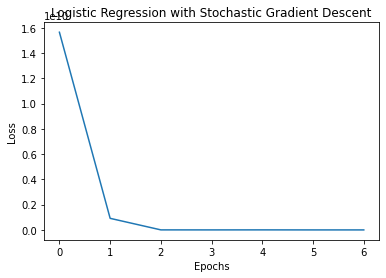

[[52190  7047]
 [ 1708 38494]]
test score: 0.9119560735727431
              precision    recall  f1-score   support

           0       0.97      0.88      0.92     59237
           1       0.85      0.96      0.90     40202

    accuracy                           0.91     99439
   macro avg       0.91      0.92      0.91     99439
weighted avg       0.92      0.91      0.91     99439



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


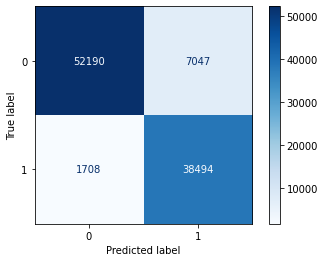

Time taken: 2.3378212451934814


In [6]:
import enum
import sys
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from io import StringIO

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

from sklearn.utils.fixes import loguniform


TRAIN_DATA_PATH = "../data/train.csv"
TEST_DATA_PATH = "../data/test.csv"

TRAIN80_DATA_PATH = "../data/train_80.csv"
TEST80_DATA_PATH = "../data/test_80.csv"

TRAIN95_DATA_PATH = "../data/train_95.csv"
TEST95_DATA_PATH = "../data/test_95.csv"

TRAIN99_DATA_PATH = "../data/train_99.csv"
TEST99_DATA_PATH = "../data/test_99.csv"

ONE_HOT_TRAIN_PATH_70 = "train_one_hot_70.csv"
ONE_HOT_TEST_PATH_70 = "test_one_hot_70.csv"

STANDARDIZED_TRAIN_DATA_PATH = "../train_standardized.csv"
STANDARDIZED_TEST_DATA_PATH = "../test_standardized.csv"

SCALED_TRAIN_DATA_PATH = "../data/train_scaled.csv"
SCALED_TEST_DATA_PATH = "../data/test_scaled.csv"

FEATURES = ['main_category', 'backers', 'country', 'usd_goal_real', 'duration_in_days']
#FEATURES_INDICES = [0,2,3,4,5]
FEATURES_INDICES = list(range(1,41))

class TransformMode(enum.Enum):
   NONE = 0
    # Whether to standardize columns in FEATURES_TO_STANDARDIZE
   STANDARDIZE_SELECTED_COLUMNS = 1
    # Whether to scale all FEATURES, final range (0,20)
   SCALE_WITH_RANGE = 2
    # Only scale 'backers', 'usd_goal_real', 'duration_in_days', using default range
   SCALE_SELECTED_COLUMNS = 3

MODE = TransformMode.NONE


def logistic_regression(train_data, test_data):
    train_y = train_data['state']
    train_X = train_data.iloc[:, FEATURES_INDICES]

    # If the only features to train on are "duration_in_days"
    # train score = 0.6, test score = 0.6
    # train_X = train_data.iloc[:, [5]]

    test_y = test_data['state']
    test_X = test_data.iloc[:, FEATURES_INDICES]
    # test_X = test_data.iloc[:, [5]]
    # examine_data(test_data)

    LR = LogisticRegression(random_state=0, solver='lbfgs', multi_class='ovr').fit(train_X, train_y)
    pred_y = LR.predict(test_X)

    evaluate(LR, test_X, test_y, pred_y)

    '''
    # Use score to evaluate
    train_score = LR.score(train_X, train_y)
    test_score = LR.score(test_X, test_y)
    print("train score: {}".format(train_score))
    print("test score: {}".format(test_score))
    '''

def sgd(train_data, test_data):
    train_y = train_data['state']
    train_X = train_data.iloc[:, FEATURES_INDICES]

    test_y = test_data['state']
    test_X = test_data.iloc[:, FEATURES_INDICES]

    old_stdout = sys.stdout
    sys.stdout = mystdout = StringIO()

    # loss="log" - logsitic regression
    # shuffle=False, since the data has already been shuffled during pre-processing
    SGD = SGDClassifier(loss="log", penalty="l2", early_stopping=True, max_iter=100, shuffle=False, verbose=1)
    # SGD.partial_fit(train_X, train_y, classes=np.unique(train_y))
    SGD.fit(train_X, train_y)
    # new_weights = SGD.coef_
    #print("Learned weights: {}".format(SGD.coef_))
    #print("Converged after {} iterations".format(SGD.n_iter_))

    sys.stdout = old_stdout
    loss_history = mystdout.getvalue()
    plot(loss_history)

    pred_y = SGD.predict(test_X)
    evaluate(SGD, test_X, test_y, pred_y)

    cmap = plt.get_cmap('Blues')
    plot_confusion_matrix(SGD, test_X, test_y, cmap=cmap)
    plt.show()

def plot(loss_history):
    loss_list = []
    for line in loss_history.split('\n'):
        if (len(line.split("loss: ")) == 1):
            continue
        loss_list.append(float(line.split("loss: ")[-1]))
    plt.figure()
    plt.plot(np.arange(len(loss_list)), loss_list)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Logistic Regression with Stochastic Gradient Descent")
    plt.show()

'''
def grid_search(train_data, test_data):
    train_y = train_data['state']
    train_X = train_data.iloc[:, FEATURES_INDICES]
    #param_grid = {'alpha': np.power(10, np.arange(-4, 1, dtype=float))}
    param_dist = {'alpha': loguniform(1e-4, 1e0)}

    SGD = SGDClassifier(loss="log", penalty="l2", max_iter=350)
    random_search = RandomizedSearchCV(SGD, param_distributions=param_dist,
                                       n_iter=50)
    random_search.fit(train_X, train_y)
    print("RandomizedSearchCV took %.2f seconds for %d candidates"
          " parameter settings." % ((time() - start), 50))
    report(random_search.cv_results_)
'''

# use mode to predict (always predict "failed")
def baseline_mode(train_data, test_data):
    # training data: 0 - 177863, 1 - 120645
    # test data: 0 - 19856, 1 - 13311

    # mode_freq = train_data['state'].value_counts().max()
    # print(train_data['state'].value_counts())

    # Get the mode (0, since mode is "failed")
    mode = train_data['state'].value_counts().idxmax()

    # How many times does 0 occur in the state column in test set?
    count_in_test = (test_data.state == mode).sum()
    # Total number of rows in test set
    test_size = len(test_data.index)
    accuracy = float(count_in_test / test_size)
    f1_score = float(count_in_test/(count_in_test + 0.5*(test_size - count_in_test)))
    print("accuracy={}, f1_score={}".format(accuracy, f1_score))

def baseline_single_feature(train_data, test_data):
    train_y = train_data['state']

    best_feature = None
    best_score = 0
    best_confusion_matrix = None
    best_pred = None

    test_y = test_data['state']
    for feature, feature_idx in zip(FEATURES, FEATURES_INDICES):
        train_X = train_data.iloc[:, [feature_idx]]
        test_X = test_data.iloc[:, [feature_idx]]
        LR = LogisticRegression(random_state=0, solver='lbfgs', multi_class='ovr').fit(train_X, train_y)
        pred_y = LR.predict(test_X)
        score, confusion = evaluate(LR, test_X, test_y, pred_y, False)
        if score > best_score:
            best_score = score
            best_feature = feature
            best_confusion_matrix = confusion
            best_pred = pred_y
    print_metrics(best_score, best_confusion_matrix, test_y, best_pred, best_feature)

def examine_data(df):
    print("\n ------ Examining data... ------")
    # print(df.shape)
    # print(df.head)
    print(df['state'].value_counts())
    print("------ Examination Done! ------")

def evaluate(model, test_X, test_y, pred_y, do_print=True):
    '''
    lbfgs: (18818+11094)/33167 = 0.90186
    liblinear: (18860+11021)/33167 = 0.9009
    newton-cg: (18884+10963)/33167 = 0.8999
    '''
    confusion = confusion_matrix(test_y, pred_y)
    score = model.score(test_X, test_y)
    if do_print:
        print_metrics(score, confusion, test_y, pred_y)
    return score, confusion

def print_metrics(score, confusion_matrix, test_y, pred_y, feature=None):
    if feature:
        print("Best feature: {}".format(feature))
    print(confusion_matrix)
    print("test score: {}".format(score))
    print(classification_report(test_y, pred_y, target_names=['0', '1']))


# ============================================

if __name__ == '__main__':
    start_time = time.time()

    train_data = None
    test_data = None
    if MODE == TransformMode.STANDARDIZE_SELECTED_COLUMNS:
        train_data = pd.read_csv(STANDARDIZED_TRAIN_DATA_PATH)
        test_data = pd.read_csv(STANDARDIZED_TEST_DATA_PATH)
    elif MODE == TransformMode.SCALE_WITH_RANGE or MODE == TransformMode.SCALE_SELECTED_COLUMNS:
        train_data = pd.read_csv(SCALED_TRAIN_DATA_PATH)
        test_data = pd.read_csv(SCALED_TEST_DATA_PATH)
    else:
        #train_data = pd.read_csv(TRAIN_DATA_PATH)
        #test_data = pd.read_csv(TEST_DATA_PATH)
        train_data = pd.read_csv(ONE_HOT_TRAIN_PATH_70)
        test_data = pd.read_csv(ONE_HOT_TEST_PATH_70)

    #logistic_regression(train_data, test_data)
    #baseline_mode(train_data, test_data)
    #baseline_single_feature(train_data, test_data)
    sgd(train_data, test_data)
    #grid_search(train_data, test_data)

    end_time = time.time()
    print("Time taken: {}".format(end_time - start_time))

Neural network

In [7]:
import enum
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier, Perceptron
from sklearn.tree import DecisionTreeClassifier

from sklearn.neural_network import MLPClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, precision_recall_fscore_support
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

TRAIN_DATA_PATH = "../data/train.csv"
TEST_DATA_PATH = "../data/test.csv"

TRAIN_STD_DATA_PATH = "../data/train_standardized.csv"
TEST_STD_DATA_PATH = "../data/test_standardized.csv"

DATA_PATH_1 = "../data/test_99.csv"
DATA_PATH_5 = "../data/test_95.csv"

ONE_HOT_TRAIN_PATH_70 = "train_one_hot_70.csv"
ONE_HOT_TEST_PATH_70 = "test_one_hot_70.csv"

#FEATURES_INDICES = [0,2,3,4,5]
FEATURES_INDICES = list(range(1,41))

def neural_network(train_data, test_data):
    train_y = train_data['state']
    train_X = train_data.iloc[:, FEATURES_INDICES]

    test_y = test_data['state']
    test_X = test_data.iloc[:, FEATURES_INDICES]

    #search(train_X, train_y)
    '''
    MLP = MLPClassifier(activation='relu', hidden_layer_sizes=50,
                    max_iter=500, alpha=1e-4, solver='adam', early_stopping=True,
                    tol=1e-4, random_state=1, learning_rate_init=0.1)
'''
    MLP = MLPClassifier(hidden_layer_sizes=(40, 40, 40), alpha=0.05)
    #MLP = MLPClassifier()
    MLP.fit(train_X, train_y)
    print("Ran for {} iterations".format(MLP.n_iter_))

    pred_y = MLP.predict(test_X)
    evaluate(MLP, test_X, test_y, pred_y)


def search(train_X, train_y):
    MLP = MLPClassifier()
    parameter_space = {
        'hidden_layer_sizes': [(15, 15, 15), (50, 50, 50), (80, 80, 80), (100, 100, 100)],
        #'activation': ['relu'],
        #'solver': ['adam'],
        #'learning_rate': ['constant', 'adaptive']
        'alpha': [0.0001, 0.05, 0.001, 0.01]
    }
    gs = GridSearchCV(estimator=MLP,
                      param_grid=parameter_space,
                      n_jobs=-1,
                      scoring='accuracy')
    gs.fit(train_X, train_y)
    print("Best score from grid search: {}".format(gs.best_score_))
    print("Best parameters from grid search: {}".format(gs.best_params_))

def evaluate(model, test_X, test_y, pred_y, do_print=True):
    confusion = confusion_matrix(test_y, pred_y)
    score = model.score(test_X, test_y)
    if do_print:
        print_metrics(score, confusion, test_y, pred_y)
    return score, confusion

def print_metrics(score, confusion_matrix, test_y, pred_y, feature=None):
    if feature:
        print("Best feature: {}".format(feature))
    print(confusion_matrix)
    print("test score: {}".format(score))
    print(classification_report(test_y, pred_y, target_names=['0', '1']))

if __name__ == '__main__':
    start_time = time.time()

    USE_SMALL = False
    '''
    if USE_SMALL:
        train_data = pd.read_csv(DATA_PATH_5)
        test_data = pd.read_csv(DATA_PATH_1)
    else:
        train_data = pd.read_csv(TRAIN_DATA_PATH)
        test_data = pd.read_csv(TEST_DATA_PATH)
    '''
    # train_data = pd.read_csv(TRAIN_DATA_PATH)
    # test_data = pd.read_csv(TEST_DATA_PATH)
    train_data = pd.read_csv(ONE_HOT_TRAIN_PATH_70)
    test_data = pd.read_csv(ONE_HOT_TEST_PATH_70)

    neural_network(train_data, test_data)

    end_time = time.time()
    print("Time taken: {}".format(end_time - start_time))

Ran for 24 iterations
[[55317  3920]
 [ 3384 36818]]
test score: 0.9265479339092307
              precision    recall  f1-score   support

           0       0.94      0.93      0.94     59237
           1       0.90      0.92      0.91     40202

    accuracy                           0.93     99439
   macro avg       0.92      0.92      0.92     99439
weighted avg       0.93      0.93      0.93     99439

Time taken: 88.69908690452576


Perceptron

In [8]:
import enum
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import Perceptron

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, precision_recall_fscore_support
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

TRAIN_DATA_PATH = "../data/train.csv"
TEST_DATA_PATH = "../data/test.csv"

ONE_HOT_TRAIN_PATH_70 = "train_one_hot_70.csv"
ONE_HOT_TEST_PATH_70 = "test_one_hot_70.csv"

#FEATURES_INDICES = [0,2,3,4,5]
FEATURES_INDICES = list(range(1,41))

def perceptron(train_data, test_data):
    train_y = train_data['state']
    train_X = train_data.iloc[:, FEATURES_INDICES]

    test_y = test_data['state']
    test_X = test_data.iloc[:, FEATURES_INDICES]

    ppn = Perceptron(penalty="l2", n_jobs=-1, early_stopping=True)
    ppn.fit(train_X, train_y)

    pred_y = ppn.predict(test_X)
    evaluate(ppn, test_X, test_y, pred_y)

def evaluate(model, test_X, test_y, pred_y, do_print=True):
    confusion = confusion_matrix(test_y, pred_y)
    score = model.score(test_X, test_y)
    if do_print:
        print_metrics(score, confusion, test_y, pred_y)
    return score, confusion

def print_metrics(score, confusion_matrix, test_y, pred_y, feature=None):
    if feature:
        print("Best feature: {}".format(feature))
    print(confusion_matrix)
    print("test score: {}".format(score))
    print(classification_report(test_y, pred_y, target_names=['0', '1']))

if __name__ == '__main__':
    start_time = time.time()

    #train_data = pd.read_csv(TRAIN_DATA_PATH)
    #test_data = pd.read_csv(TEST_DATA_PATH)
    train_data = pd.read_csv(ONE_HOT_TRAIN_PATH_70)
    test_data = pd.read_csv(ONE_HOT_TEST_PATH_70)

    perceptron(train_data, test_data)

    end_time = time.time()
    print("Time taken: {}".format(end_time - start_time))

[[53720  5517]
 [ 7550 32652]]
test score: 0.8685928056396384
              precision    recall  f1-score   support

           0       0.88      0.91      0.89     59237
           1       0.86      0.81      0.83     40202

    accuracy                           0.87     99439
   macro avg       0.87      0.86      0.86     99439
weighted avg       0.87      0.87      0.87     99439

Time taken: 4.103998422622681


Ada-boost

In [9]:
import enum
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier, Perceptron
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import AdaBoostClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, precision_recall_fscore_support
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

TRAIN_DATA_PATH = "../data/train.csv"
TEST_DATA_PATH = "../data/test.csv"

ONE_HOT_TRAIN_PATH_70 = "train_one_hot_70.csv"
ONE_HOT_TEST_PATH_70 = "test_one_hot_70.csv"

#FEATURES_INDICES = [0,2,3,4,5]
FEATURES_INDICES = list(range(1,41))

def ada_boost(train_data, test_data):
    train_y = train_data['state']
    train_X = train_data.iloc[:, FEATURES_INDICES]

    test_y = test_data['state']
    test_X = test_data.iloc[:, FEATURES_INDICES]

    #search(train_X, train_y)
    dt = DecisionTreeClassifier(criterion="entropy", max_depth=5)
    ADA = AdaBoostClassifier(learning_rate=0.1, n_estimators=100, base_estimator=dt)
    ADA.fit(train_X, train_y)

    pred_y = ADA.predict(test_X)
    evaluate(ADA, test_X, test_y, pred_y)

def search(train_X, train_y):
    param_depth=[5, 10, 15]
    for depth in param_depth:
        param_n_estimators = [20, 50, 80, 100]
        param_learning_rates = [0.1, 0.3, 0.5, 0.75, 1]
        param_grid = [{'n_estimators': param_n_estimators,
                       'learning_rate': param_learning_rates
                      }]
        dt = DecisionTreeClassifier(criterion="entropy", max_depth=depth)
        gs = GridSearchCV(estimator=AdaBoostClassifier(base_estimator=dt),
                          param_grid=param_grid,
                          scoring='accuracy')
        gs.fit(train_X, train_y)
        print("====== Stats for depth={}".format(depth))
        print("Best score from grid search: {}".format(gs.best_score_))
        print("Best parameters from grid search: {}\n".format(gs.best_params_))


def evaluate(model, test_X, test_y, pred_y, do_print=True):
    confusion = confusion_matrix(test_y, pred_y)
    score = model.score(test_X, test_y)
    if do_print:
        print_metrics(score, confusion, test_y, pred_y)
    return score, confusion

def print_metrics(score, confusion_matrix, test_y, pred_y, feature=None):
    if feature:
        print("Best feature: {}".format(feature))
    print(confusion_matrix)
    print("test score: {}".format(score))
    print(classification_report(test_y, pred_y, target_names=['0', '1']))

if __name__ == '__main__':
    start_time = time.time()

    #train_data = pd.read_csv(TRAIN_DATA_PATH)
    #test_data = pd.read_csv(TEST_DATA_PATH)
    train_data = pd.read_csv(ONE_HOT_TRAIN_PATH_70)
    test_data = pd.read_csv(ONE_HOT_TEST_PATH_70)

    ada_boost(train_data, test_data)

    end_time = time.time()
    print("Time taken: {}".format(end_time - start_time))

[[55496  3741]
 [ 2932 37270]]
test score: 0.932893532718551
              precision    recall  f1-score   support

           0       0.95      0.94      0.94     59237
           1       0.91      0.93      0.92     40202

    accuracy                           0.93     99439
   macro avg       0.93      0.93      0.93     99439
weighted avg       0.93      0.93      0.93     99439

Time taken: 72.98464012145996


Bagging

In [10]:
import enum
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier, Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, precision_recall_fscore_support
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

TRAIN_DATA_PATH = "../data/train.csv"
TEST_DATA_PATH = "../data/test.csv"

ONE_HOT_TRAIN_PATH_70 = "train_one_hot_70.csv"
ONE_HOT_TEST_PATH_70 = "test_one_hot_70.csv"

#FEATURES_INDICES = [0,2,3,4,5]
FEATURES_INDICES = list(range(1,41))

def bagging(train_data, test_data):
    train_y = train_data['state']
    train_X = train_data.iloc[:, FEATURES_INDICES]

    test_y = test_data['state']
    test_X = test_data.iloc[:, FEATURES_INDICES]

    KNN = KNeighborsClassifier(n_neighbors=15)
    DT = DecisionTreeClassifier(criterion="entropy", max_depth=10)
    # Got "ZeroDivisionError: Weights sum to zero, can't be normalized" for both perceptron and SGD
    #PPN = Perceptron(penalty="l2", n_jobs=-1, early_stopping=True)
    #SGD = SGDClassifier(loss="log", penalty="l2", early_stopping=True, shuffle=False, verbose=0)

    bag = BaggingClassifier(base_estimator=DecisionTreeClassifier(criterion="entropy", max_depth=10),
                            n_estimators=14)
    bag.fit(train_X, train_y)

    pred_y = bag.predict(test_X)
    evaluate(bag, test_X, test_y, pred_y)


def evaluate(model, test_X, test_y, pred_y, do_print=True):
    confusion = confusion_matrix(test_y, pred_y)
    score = model.score(test_X, test_y)
    if do_print:
        print_metrics(score, confusion, test_y, pred_y)
    return score, confusion

def print_metrics(score, confusion_matrix, test_y, pred_y, feature=None):
    if feature:
        print("Best feature: {}".format(feature))
    print(confusion_matrix)
    print("test score: {}".format(score))
    print(classification_report(test_y, pred_y, target_names=['0', '1']))

if __name__ == '__main__':
    start_time = time.time()

    #train_data = pd.read_csv(TRAIN_DATA_PATH)
    #test_data = pd.read_csv(TEST_DATA_PATH)
    train_data = pd.read_csv(ONE_HOT_TRAIN_PATH_70)
    test_data = pd.read_csv(ONE_HOT_TEST_PATH_70)

    bagging(train_data, test_data)

    end_time = time.time()
    print("Time taken: {}".format(end_time - start_time))

[[55507  3730]
 [ 3086 37116]]
test score: 0.931455465159545
              precision    recall  f1-score   support

           0       0.95      0.94      0.94     59237
           1       0.91      0.92      0.92     40202

    accuracy                           0.93     99439
   macro avg       0.93      0.93      0.93     99439
weighted avg       0.93      0.93      0.93     99439

Time taken: 15.29805874824524


Gradient boost

In [11]:
import enum
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, precision_recall_fscore_support
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

from xgboost import XGBClassifier

TRAIN_DATA_PATH = "../data/train.csv"
TEST_DATA_PATH = "../data/test.csv"

TRAIN_STD_DATA_PATH = "../data/train_standardized.csv"
TEST_STD_DATA_PATH = "../data/test_standardized.csv"

ONE_HOT_TRAIN_PATH_70 = "train_one_hot_70.csv"
ONE_HOT_TEST_PATH_70 = "test_one_hot_70.csv"

#FEATURES_INDICES = [0,2,3,4,5]
FEATURES_INDICES = list(range(1,41))

def gradient_boost(train_data, test_data):
    train_y = train_data['state']
    train_X = train_data.iloc[:, FEATURES_INDICES]

    test_y = test_data['state']
    test_X = test_data.iloc[:, FEATURES_INDICES]

    #search(train_X, train_y)
    #search_xgboost(train_X, train_y)
    gd = HistGradientBoostingClassifier(loss='auto', max_bins=200, max_depth=10, max_leaf_nodes=35)

    #gd = XGBClassifier()
    gd.fit(train_X, train_y)

    pred_y = gd.predict(test_X)
    evaluate(gd, test_X, test_y, pred_y)


def search(train_X, train_y):
    param_learning_rates = [0.1, 0.3, 0.5]
    param_max_leaf_nodes = [31, 35, 40]
    param_max_bins = [150, 200, 250]
    param_max_depth = [5, 7, 10]
    #param_min_samples_leaf = [25, 30, 35]
    #param_gamma = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0]
    param_grid = [{#'learning_rate': param_learning_rates,
                   'max_leaf_nodes': param_max_leaf_nodes,
                   'max_bins':param_max_bins,
                   'max_depth': param_max_depth
                   #'min_samples_leaf': param_min_samples_leaf
                   }]
    gs = GridSearchCV(estimator=HistGradientBoostingClassifier(loss='binary_crossentropy', learning_rate=0.1),
                      param_grid=param_grid,
                      n_jobs=-1,
                      scoring='accuracy')

    gs.fit(train_X, train_y)
    print("Best score from grid search: {}".format(gs.best_score_))
    print("Best parameters from grid search: {}".format(gs.best_params_))

def search_xgboost(train_X, train_y):
    param_eta = [0.01, 0.1, 0.2]
    param_max_depth = [5, 8, 10]
    param_grid = [{  'eta': param_eta,
                     'max_depth': param_max_depth
    }]
    XGB = XGBClassifier()
    gs = GridSearchCV(estimator=XGB,
                      param_grid=param_grid,
                      n_jobs=-1,
                      scoring='accuracy')

    gs.fit(train_X, train_y)
    print("Best score from grid search: {}".format(gs.best_score_))
    print("Best parameters from grid search: {}".format(gs.best_params_))

def evaluate(model, test_X, test_y, pred_y, do_print=True):
    confusion = confusion_matrix(test_y, pred_y)
    score = model.score(test_X, test_y)
    if do_print:
        print_metrics(score, confusion, test_y, pred_y)
    return score, confusion

def print_metrics(score, confusion_matrix, test_y, pred_y, feature=None):
    if feature:
        print("Best feature: {}".format(feature))
    print(confusion_matrix)
    TP = confusion_matrix[0][0]
    FP = confusion_matrix[0][1]
    FN = confusion_matrix[1][0]
    f1 = float(TP/(TP+0.5*(FP+FN)))
    print("test score: {}".format(score))
    print("F1 score: {}".format(f1))
    print(classification_report(test_y, pred_y, target_names=['0', '1']))

if __name__ == '__main__':
    start_time = time.time()

    # train_data = pd.read_csv(TRAIN_DATA_PATH)
    # test_data = pd.read_csv(TEST_DATA_PATH)
    train_data = pd.read_csv(ONE_HOT_TRAIN_PATH_70)
    test_data = pd.read_csv(ONE_HOT_TEST_PATH_70)

    gradient_boost(train_data, test_data)

    end_time = time.time()
    print("Time taken: {}".format(end_time - start_time))

/usr/local/lib/python3.7/dist-packages/sklearn/experimental/enable_hist_gradient_boosting.py:17: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  "Since version 1.0, "


[[55636  3601]
 [ 3006 37196]]
test score: 0.9335572562073231
F1 score: 0.9439510006023125
              precision    recall  f1-score   support

           0       0.95      0.94      0.94     59237
           1       0.91      0.93      0.92     40202

    accuracy                           0.93     99439
   macro avg       0.93      0.93      0.93     99439
weighted avg       0.93      0.93      0.93     99439

Time taken: 15.608320474624634
